# Standard tests for shells and their convergence behavior

In [1]:
import torch
from scipy.interpolate import RegularGridInterpolator
import meshio
import numpy as np
import matplotlib.pyplot as plt
from torchfem import Shell
from torchfem.mesh import rect_tri
from torchfem.examples import get_example_file
from torchfem.materials import IsotropicElasticityPlaneStress

torch.set_default_dtype(torch.float64)

## Fully clamped plate problem 

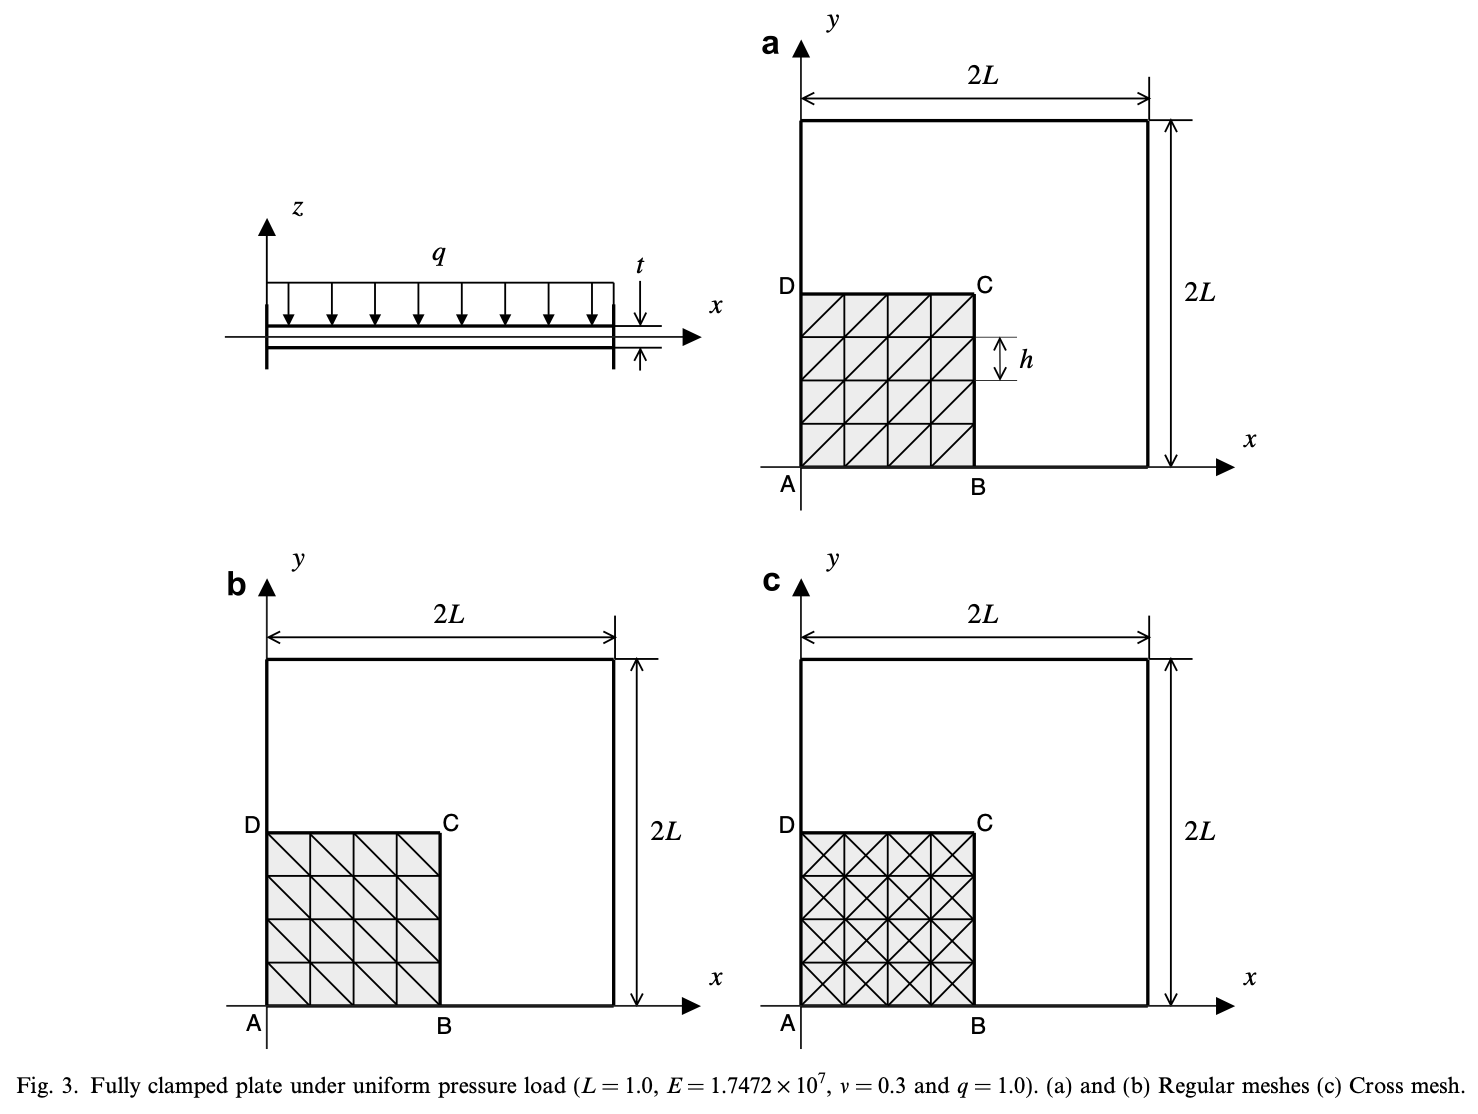

P.S. Lee, H.C. Noh, K.J. Bathe: "Insight into 3-node triangular shell finite elements: the eﬀects of element isotropy and mesh patterns", *Computers and Structures*, 2006, pp. 404-418, 10.1016/j.compstruc.2006.10.006

R.H. MacNeal and R.L. Harder: "A proposed standard set of problems to Test Finite Element Accuracy", *Finite Elements in Analysis and Design I*, 1985, pp. 3-20.

In [2]:
q = 1.0e-4  # Distributed load per unit area
E = 1.7472e7  # Young's modulus
nu = 0.3  # Poisson's ratio
t = 0.0001  # Thickness of the shell

In [3]:
# Extract reference solution obtained from Abaqus with 48x48 S8R elements
reference = meshio.read(get_example_file(f"clamped_plate_uniform_S8R.vtk"))
M = 49
x = reference.points[: M**2, 0]
y = reference.points[: M**2, 1]
w = reference.point_data["U"][: M**2, 2]

# Interpolate reference solution to nodes
interp = RegularGridInterpolator((np.unique(x), np.unique(y)), w.reshape(M, M))

In [4]:
N = [4, 8, 16, 32]
variants = ["up", "down", "center"]
mesh_sizes = {variant: [] for variant in variants}
errors = {variant: [] for variant in variants}

for variant in variants:
    for n in N:
        # Material parameters
        material = IsotropicElasticityPlaneStress(E=E, nu=nu)

        # Define nodes and element of the plate
        nodes, elements = rect_tri(n + 1, n + 1, variant=variant)
        nodes = torch.hstack([nodes, torch.zeros((len(nodes), 1))])

        # Define Shell model
        plate = Shell(nodes, elements, material, thickness=t)

        # Apply distributed load in the negative z-direction
        areas = plate.integrate_field()
        for i, area in enumerate(areas):
            plate.forces[elements[i], 2] -= q * area / 3.0

        # Apply displacement boundary conditions
        plate.constraints[nodes[:, 0] < 0.01, :] = True
        plate.constraints[nodes[:, 1] < 0.01, :] = True
        plate.constraints[nodes[:, 0] > 0.99, 0] = True
        plate.constraints[nodes[:, 0] > 0.99, 4] = True
        plate.constraints[nodes[:, 1] > 0.99, 1] = True
        plate.constraints[nodes[:, 1] > 0.99, 3] = True

        # Solve
        u, f, _, _, _ = plate.solve(method="spsolve")

        # Compute error with respect to reference solutio
        w_i = interp(nodes[:, :2])
        error = np.linalg.norm(w_i - u[:, 2].numpy()) / np.linalg.norm(w_i)

        # Store error and mesh size
        errors[variant].append(error)
        mesh_sizes[variant].append(1 / n)

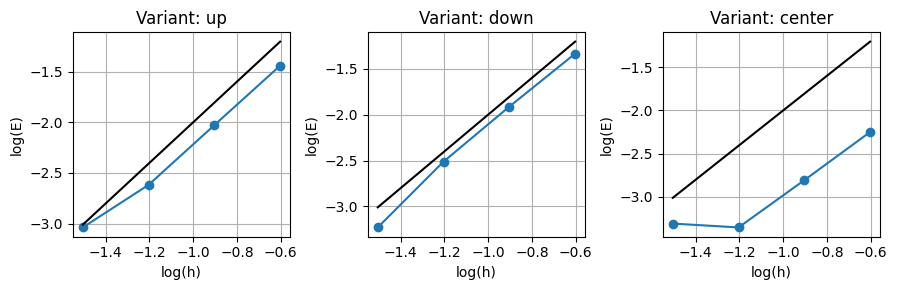

In [5]:
fig, ax = plt.subplots(1, len(variants), figsize=(9, 3))
for i, variant in enumerate(variants):
    logh = np.log10(mesh_sizes[variant])
    loge = np.log10(errors[variant])
    ax[i].plot(logh, loge, marker="o")
    ax[i].plot(logh, 2 * logh, "k")
    ax[i].grid(True)
    ax[i].set_xlabel("log(h)")
    ax[i].set_ylabel("log(E)")
    ax[i].set_title(f"Variant: {variant}")

plt.tight_layout()
plt.show()

## Cantilever bending plate problem


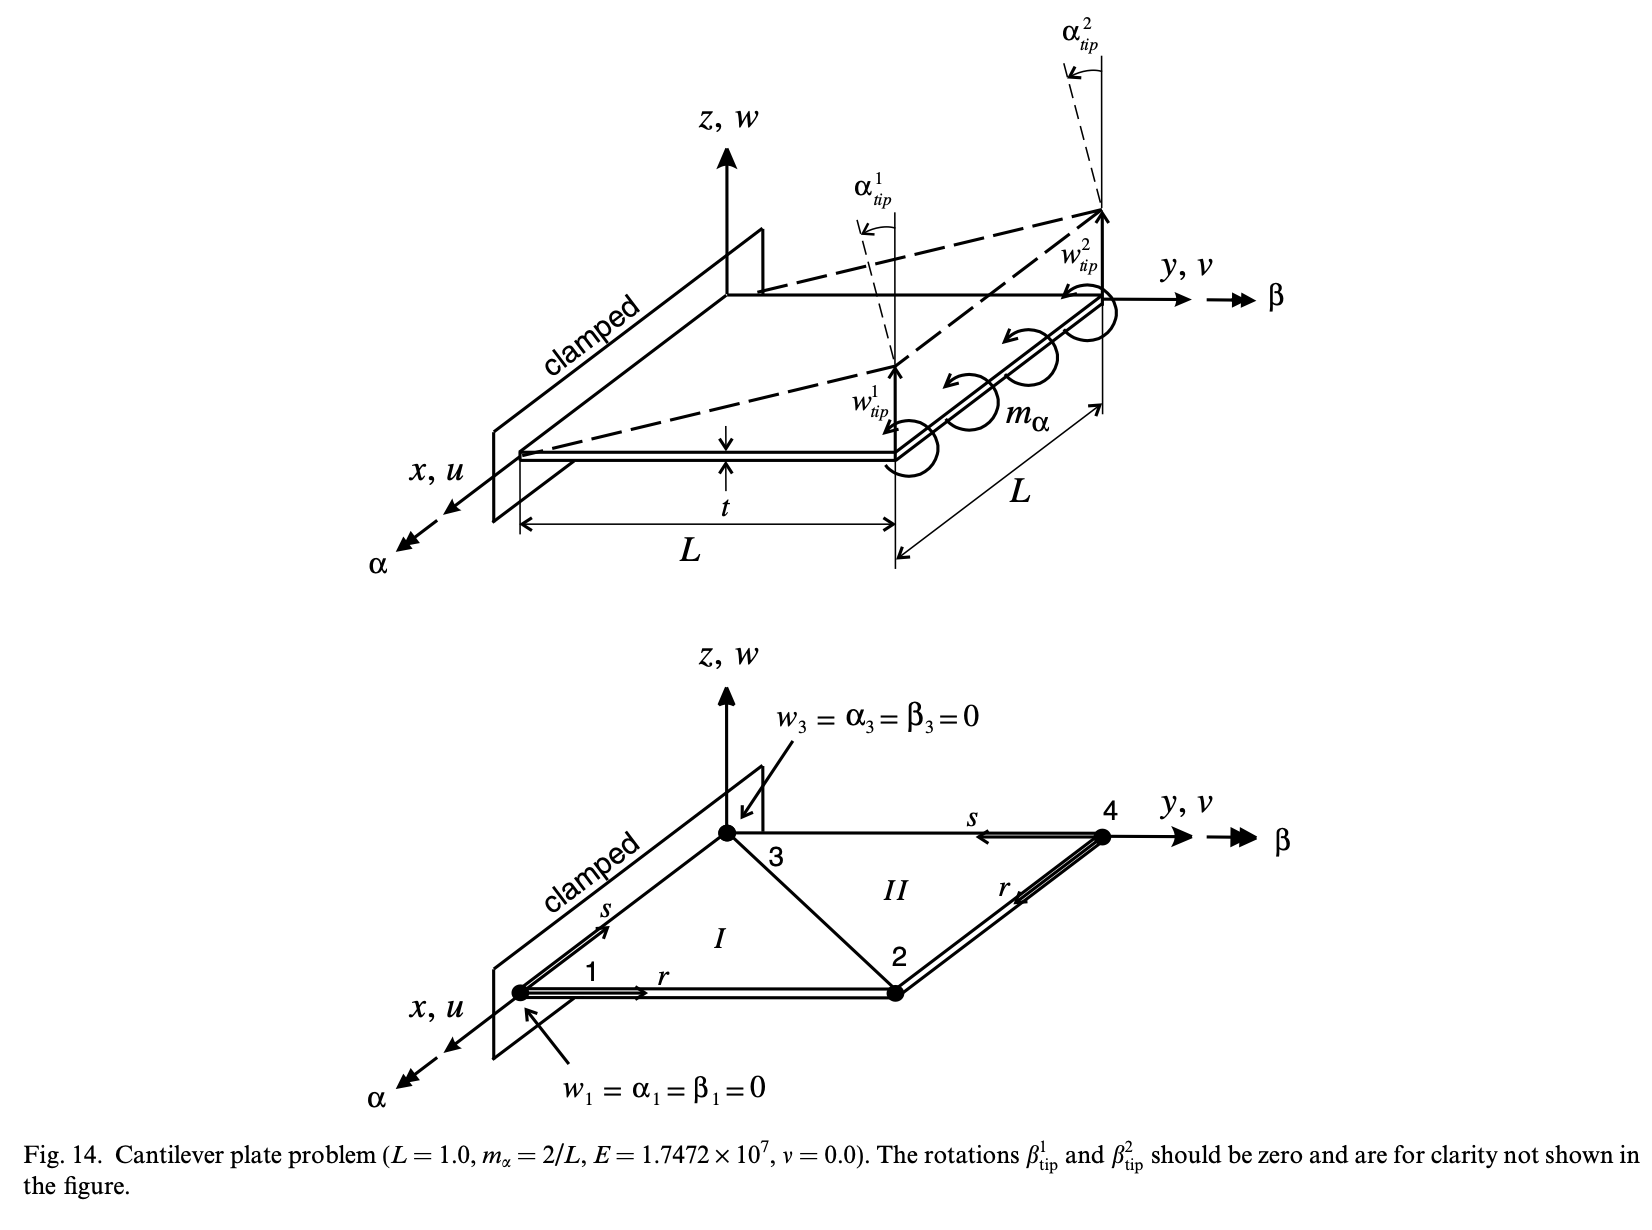


P.S. Lee, H.C. Noh, K.J. Bathe: "Insight into 3-node triangular shell finite elements: the eﬀects of element isotropy and mesh patterns", *Computers and Structures*, 2006, pp. 404-418, 10.1016/j.compstruc.2006.10.006

In [6]:
m = 1.0  # Distributed moment per length
E = 1.7472e7  # Young's modulus
nu = 0.0  # Poisson's ratio
t = 0.0001  # Thickness of the shell

In [7]:
# Material parameters
material = IsotropicElasticityPlaneStress(E=E, nu=nu)

# Define nodes and element of the plate
nodes = torch.tensor(
    [[1.0, 0.0, 0.0], [1.0, 1.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0]]
)
elements = torch.tensor([[0, 1, 2], [1, 2, 3]])

# Define Shell model
plate = Shell(nodes, elements, material, thickness=t)


# Boundary conditions
tip = nodes[:, 1] > 0.99
plate.constraints[~tip, :] = True
plate.forces[tip, 3] = m

u, f, _, _, _ = plate.solve(method="spsolve")


print(f"Displacements at tip are {u[tip, 2]}. Should be close to 686.13 each.")
print(f"Rotations around x at tip are {u[tip, 3]}. Should be close to 1373.63 each.")
print(f"Rotations around y at tip are {u[tip, 4]}. Should be close to 0.0 each.")

plate.plot(node_property={"U": u[:, :3]})

Displacements at tip are tensor([686813.1868, 686813.1868]). Should be close to 686.13 each.
Rotations around x at tip are tensor([1373626.3736, 1373626.3736]). Should be close to 1373.63 each.
Rotations around y at tip are tensor([1.2806e-09, 5.7428e-10]). Should be close to 0.0 each.


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Two-sided clamped plate

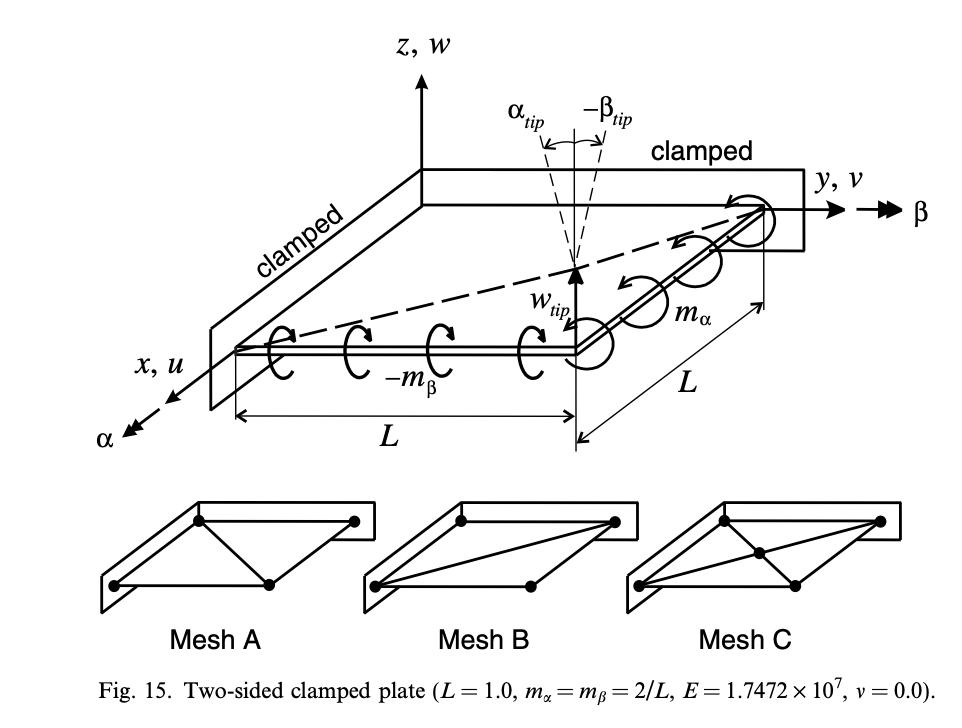

P.S. Lee, H.C. Noh, K.J. Bathe: "Insight into 3-node triangular shell finite elements: the eﬀects of element isotropy and mesh patterns", *Computers and Structures*, 2006, pp. 404-418, 10.1016/j.compstruc.2006.10.006

In [8]:
m = 1.0  # Distributed moment per length
E = 1.7472e7  # Young's modulus
nu = 0.0  # Poisson's ratio

In [9]:
variants = ["up", "down", "center"]

# Material parameters
material = IsotropicElasticityPlaneStress(E=E, nu=nu)

for variant in variants:
    for t in [0.001, 0.0001]:
        # Define nodes and element of the plate
        nodes, elements = rect_tri(2, 2, variant=variant)
        nodes = torch.hstack([nodes, torch.zeros((len(nodes), 1))])

        # Define Shell model
        plate = Shell(nodes, elements, material, thickness=t)

        # Boundary conditions
        left = nodes[:, 1] < 0.01
        right = nodes[:, 1] > 0.99
        back = nodes[:, 0] < 0.01
        front = nodes[:, 0] > 0.99
        plate.constraints[left, :] = True
        plate.constraints[back, :] = True
        plate.forces[right, 3] = m
        plate.forces[front, 4] = -m

        u, f, _, _, _ = plate.solve(method="spsolve")

        strain_energy = 0.5 * t * torch.einsum("...i, ...i->", u, f)
        print(
            f"Variant: {variant:6s} Thickness: {t:5f}  "
            f"-  Strain energy: {strain_energy}"
        )

Variant: up     Thickness: 0.001000  -  Strain energy: 0.6868144230702472
Variant: up     Thickness: 0.000100  -  Strain energy: 68.68131991758226
Variant: down   Thickness: 0.001000  -  Strain energy: 0.6868131868131864
Variant: down   Thickness: 0.000100  -  Strain energy: 68.6813186813186
Variant: center Thickness: 0.001000  -  Strain energy: 0.845310995480689
Variant: center Thickness: 0.000100  -  Strain energy: 84.53085621951972
